In [77]:
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import os
%matplotlib inline
warnings.filterwarnings('ignore')

In [78]:
train_df = pd.read_csv("./input/train_data.csv")
test_df = pd.read_csv("./input/test_data.csv")

In [79]:
print("train shape：", train_df.shape)
print("test shape：", test_df.shape)

train shape： (21000, 13)
test shape： (9000, 12)


## 特徴量エンジニアリング

In [80]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
def preprocess(df):
    df["area"] = LabelEncoder().fit_transform(df["area"])
    return df 

In [81]:
def fea_eng(df):
    #数値系
    #家族の人数
    df["family_num"] = df["partner"] + df["num_child"]
    
    #年間の勤務時間
    df["work_time_per_year"] = 8*245*df["service_length"] + 12*df["overtime"]*df["service_length"]
    
    #自由時間
    df["free_time_per_year"] = 24*365 - 8*365 - df["study_time"]*48 - df["overtime"]*12 - df["commute"]*365

    return df

In [82]:
%%time
train_df = preprocess(train_df)
train_df = fea_eng(train_df)

test_df = preprocess(test_df)
test_df = fea_eng(test_df)

CPU times: user 28.2 ms, sys: 8.32 ms, total: 36.5 ms
Wall time: 38.6 ms


In [83]:
train_df.head()

,id,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,salary,family_num,work_time_per_year,free_time_per_year
0,0,1,44,24,2,1,2,1,24,2.0,1.6,9.2,428.074887,3,49689.6,5049.6
1,1,2,31,10,1,0,0,0,13,9.0,0.7,12.4,317.930517,0,27414.4,5003.7
2,2,2,36,14,1,0,0,2,14,4.0,0.4,16.9,357.350316,0,30279.2,5299.2
3,3,0,22,26,2,0,0,0,4,3.0,0.4,6.1,201.310911,0,8132.8,5476.8
4,4,0,25,46,2,0,0,1,5,3.0,0.2,4.9,178.067475,0,10094.0,5564.2


In [84]:
test_df.head()

,id,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,family_num,work_time_per_year,free_time_per_year
0,0,3,39,46,2,1,5,1,19,1.0,1.8,14.2,6,40477.6,4964.6
1,1,1,31,11,1,0,0,4,0,0.0,0.5,18.6,0,0.0,5434.3
2,2,0,20,24,2,1,2,0,2,2.0,1.2,2.3,3,3975.2,5278.4
3,3,0,28,0,2,0,0,0,10,3.0,0.3,0.0,0,19600.0,5586.5
4,4,1,41,23,2,0,0,0,23,3.0,0.5,10.1,0,47867.6,5392.3


## NNモデル

In [85]:
features = [c for c in train_df.columns if c not in ['id', 'salary', "position", "area", "sex", "partner", "education", "age_generation"]]
target = train_df["salary"]
target = target.map(np.log1p)

In [86]:
scaler = StandardScaler()
train = scaler.fit_transform(train_df[features].values)
test = scaler.fit_transform(test_df[features].values)

In [87]:
batch_size = 128
epochs = 100
early_stopping = EarlyStopping(monitor = "val_loss", patience = 20, restore_best_weights = True)

folds = KFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target)):
    print("Fold {}".format(fold_ + 1))
    
    model = Sequential()
    model.add(Dense(256, activation = "relu", input_shape = (train[trn_idx].shape[1],)))
    model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(Dense(1, activation = "linear"))
    model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["mae"])
    
    history = model.fit(train[trn_idx], 
                                target[trn_idx], 
                                batch_size = batch_size, 
                                epochs = epochs, 
                                verbose = 1,
                                validation_data = (train[val_idx], target[val_idx]),
                                callbacks = [early_stopping])
    
    oof[val_idx] = model.predict(train[val_idx]).reshape(len(train[val_idx]), )
    predictions += model.predict(test).reshape(len(test), ) / folds.n_splits
    
print("CV score: {:<8.5f}".format(mean_absolute_error(np.expm1(target), np.expm1(oof))))

Fold 1
Train on 18900 samples, validate on 2100 samples
Epoch 1/100
18900/18900 [==============================] - 2s 91us/step - loss: 2.8648 - mae: 1.2081 - val_loss: 0.7376 - val_mae: 0.6527
Epoch 2/100
18900/18900 [==============================] - 1s 46us/step - loss: 0.5103 - mae: 0.5469 - val_loss: 0.1216 - val_mae: 0.2685
Epoch 3/100
18900/18900 [==============================] - 1s 46us/step - loss: 0.2500 - mae: 0.3920 - val_loss: 0.0574 - val_mae: 0.1704
Epoch 4/100
18900/18900 [==============================] - 1s 45us/step - loss: 0.2099 - mae: 0.3611 - val_loss: 0.0459 - val_mae: 0.1641
Epoch 5/100
18900/18900 [==============================] - 1s 46us/step - loss: 0.1803 - mae: 0.3353 - val_loss: 0.0496 - val_mae: 0.1753
Epoch 6/100
18900/18900 [==============================] - 1s 45us/step - loss: 0.1645 - mae: 0.3211 - val_loss: 0.0372 - val_mae: 0.1397
Epoch 7/100
18900/18900 [==============================] - 1s 46us/step - loss: 0.1598 - mae: 0.3166 - val_loss: 0.0

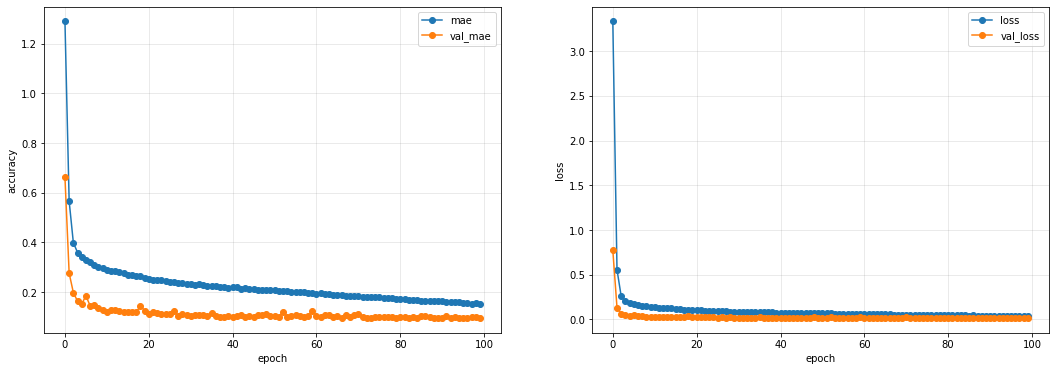

In [88]:
plt.figure(figsize = (18,6))
# mae
plt.subplot(1, 2, 1)
plt.plot(history.history["mae"], label = "mae", marker = "o")
plt.plot(history.history["val_mae"], label = "val_mae", marker = "o")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("accuracy")
#plt.title("")
plt.legend(loc = "best")
plt.grid(color = 'gray', alpha = 0.2)

# loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label = "loss", marker = "o")
plt.plot(history.history["val_loss"], label = "val_loss", marker = "o")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.title("")
plt.legend(loc = "best")
plt.grid(color = 'gray', alpha = 0.2)

plt.show()

## 提出用ファイル作成

In [89]:
predictions = np.expm1(predictions)
sub_df = pd.DataFrame({"id":test_df["id"].values})
sub_df["y"] = predictions
sub_df.to_csv("./output/NN_k-fold10_epoch100_averaging.csv", index=False)